# Simulation 4 - ATLAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

## Random Feature

In [2]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        return result.T

data generation

In [3]:
n=2000
p=8
np.random.seed(0)
data=np.random.uniform(0,1, (n,p)) #n points
np.random.seed(1)
noise=np.random.normal(0,1,n)

#function
def g1(x):
    return -2*np.sin(2*np.pi*x)
def g2(x):
    return x**2-1/3
def g3(x):
    return x-1/2
def g4(x):
    return np.exp(x)+np.exp(1)-1
a1=1
a4=4
def a2(x):
    return 2/np.sqrt(2*np.pi)*np.exp(-(x-1)**2/2)
def a3(x):
    return 3*np.cos(2*np.pi*x)

y=a1*g1(data[:,0])+a2(data[:,0])*g2(data[:,1])+a3(data[:,0])*g3(data[:,2])+a4*g4(data[:,3])+noise


np.random.seed(2)
calibration_x=np.random.uniform(0,1, (n,p)) #n points
np.random.seed(3)
calibration_noise=np.random.normal(0,1,n)
calibration_y=a1*g1(calibration_x[:,0])+a2(calibration_x[:,0])*g2(calibration_x[:,1])+a3(calibration_x[:,0])*g3(calibration_x[:,2])+a4*g4(calibration_x[:,3])+calibration_noise



np.random.seed(4)
test_x=np.random.uniform(0,1, (2*n,p)) #n points
np.random.seed(5)
test_noise=np.random.normal(0,1,2*n)
test_y=a1*g1(test_x[:,0])+a2(test_x[:,0])*g2(test_x[:,1])+a3(test_x[:,0])*g3(test_x[:,2])+a4*g4(test_x[:,3])+test_noise

In [4]:
train_x=data
train_y=y

total_x=np.vstack((train_x,calibration_x))
total_y=np.hstack((train_y,calibration_y))

nntrain_x = torch.from_numpy(train_x).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 
nntest_x= torch.from_numpy(test_x).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y).float())

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## KRR

In [5]:
t0=time.time()
krr = KernelRidge(kernel='rbf',gamma=1/2)
param_grid = {
    'alpha': [1e-7,1e-6,1e-5,1e-4,1e-3]
}

kf = KFold(n_splits=5, shuffle=True)  
grid_search = GridSearchCV(krr, param_grid, cv=kf)
grid_search.fit(total_x, total_y)

print("Best parameters found: ", grid_search.best_params_)

best_krr = grid_search.best_estimator_
krr_pred = best_krr.predict(test_x)

t1=time.time()-t0
print(mean_squared_error(test_y,krr_pred))
print("Time:",t1)

Best parameters found:  {'alpha': 0.001}
1.2646023956203407
Time: 12.255845546722412


## RF

In [67]:
t0=time.time()
model=Ridge()
param_grid = {
    'alpha': [1e-7,1e-6,1e-5,1e-4,1e-3]
}
rff=RandomFourierFeature(p,500,kernel='G',gamma=1)
total_feature=rff.transform(total_x)
test_feature=rff.transform(test_x)

kf = KFold(n_splits=5, shuffle=True)  
grid_search = GridSearchCV(model, param_grid, cv=kf)
grid_search.fit(total_feature, total_y)

print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
rf_pred = best_model.predict(test_feature)

t1=time.time()-t0
print(mean_squared_error(test_y,rf_pred))
print("Time:",t1)

Best parameters found:  {'alpha': 0.001}
1.239894330268793
Time: 1.2211461067199707


# MLKM

In [34]:
rff1=RandomFourierFeature(p,64,kernel='G',gamma=1)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=1)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(64, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0.01)


def MultiLayerKfold(kfold,param_grid):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    param_error=[]
    for param in tqdm(param_grid):
        k_error=[]
        for k in range(kfold):
            Kfold_val_x, Kfold_val_y=nntrain_x[int(n/5)*k:int(n/5)*(k+1)], nntrain_y[int(n/5)*k:int(n/5)*(k+1)]
            Kfold_train_x = torch.cat((nntrain_x[:int(n/5)*k],nntrain_x[int(n/5)*(k+1):]),dim = 0)
            Kfold_train_y = torch.cat((nntrain_y[:int(n/5)*k],nntrain_y[int(n/5)*(k+1):]),dim = 0)
           
            net = KernelNet()  #### KernelNet!
            net = net.to(device)
            torch.manual_seed(1)
            net.apply(init_weights)
            criterion=nn.MSELoss() 
            optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=param) #optim.Adam(...)
            kfoldtrain_loader = DataLoader(mydataset(Kfold_train_x, Kfold_train_y),batch_size=128, shuffle=True)
            
            for epoch in range(2000): 
                for x, y in kfoldtrain_loader: #for batch, (x, y) in enumerate(train_loader): 
                    x, y = x.to(device), y.to(device)
                    # Compute prediction error
                    y_pred = net(x)
                    y_pred = torch.squeeze(y_pred)
                    train_loss = criterion(y_pred, y)
                    # Backpropagation
                    optimizer.zero_grad() 
                    train_loss.backward()
                    optimizer.step()
            
            x0=Kfold_val_x[:].float()
            with torch.no_grad():
                x0 = x0.to(device)
                val_pred = net(x0)
            
            k_error.append(mean_squared_error(val_pred,Kfold_val_y))
        
        param_error.append(np.mean(k_error))
        
    print(param_error) 
    return param_grid[np.argmin(param_error)]  

bestweight=MultiLayerKfold(5,[1e-7,1e-6,1e-5,1e-4,1e-3])     
print(bestweight)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [19:04<00:00, 228.85s/it]

[1.3374951, 1.3374845, 1.3373827, 1.3365072, 1.3235145]
0.001


In [82]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=128, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=bestweight) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        train_pred = net(x0)
    
    x0=torch.from_numpy(test_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        test_pred = net(x0)
    
    kernelnn_trainloss.append(mean_squared_error(train_pred,train_y))
    kernelnn_testloss.append(mean_squared_error(test_pred,test_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {kernelnn_trainloss[-1]}
            Test set - loss: {kernelnn_testloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=64, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 92.70778414510848
            Test set - loss: 95.09516271548794
            
epoch 100
            Train set - loss: 1.4670591438206735
            Test set - loss: 1.601612576925769
            
epoch 200
            Train set - loss: 1.1682497704766674
            Test set - loss: 1.3169798887109578
            
epoch 300
            Train set - loss: 1.0878814153502847
            Test set - loss: 1.2448018302774069
            
epoch 400
            Train set - loss: 1.0931897327356732
            Test set - loss: 1.2553774669308138
            
epoch 500
            Train set - loss: 1.0241041080258455
            Test set - loss: 1.1980425999651534
            
epoch 600
            Train set - loss: 1.0100079290529305
            Test set - loss: 1.198016176750919
            
epoch 700
            Train set - lo

In [83]:
kernel_x0=torch.from_numpy(test_x[:]).float()
with torch.no_grad():
    kernel_x0 = kernel_x0.to(device)
    kernel_pred = net(kernel_x0)

### Conformal confidence bands for MLKM

In [84]:
##conformal prediction
#predict

coverage=0
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i]).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(calibration_x))):
    x0=torch.from_numpy(calibration_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    if fFFf < 0:
        continue
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-calibration_y[i])/(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1))])
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(score)+1)*0.95
a=sorted_score[int(np.ceil(q))]

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
    pred_xall.append(test_x[i][0])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(test_y[i])
    dist.append(dd)
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 4000/4000 [00:02<00:00, 1567.34it/s]

length 4.297548873484135
95 coverage 0.945


  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:01<00:00, 1592.67it/s]


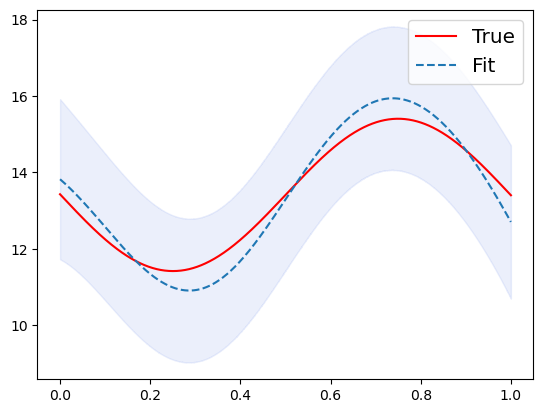

In [85]:
np.random.seed(10)
plot_x=np.random.uniform(0,1, (n,p)) #n points
plot_x[:,1:]=1/2
np.random.seed(3)
plot_noise=np.random.normal(0,1,n)
plot_y=a1*g1(plot_x[:,0])+a2(plot_x[:,0])*g2(plot_x[:,1])+a3(plot_x[:,0])*g3(plot_x[:,2])+a4*g4(plot_x[:,3])+plot_noise

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(plot_x))):
    x0=torch.from_numpy(plot_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0

    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<plot_y[i] and pred.detach().numpy()[0][0]+dd>plot_y[i]:
        coverage=coverage+1
    pred_xall.append(plot_x[i][0])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(plot_y[i])
    dist.append(dd)
    
band=np.array([pred_xall,pred_yall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plx=np.linspace(0,1,1000)
ply=a1*g1(plx)+a2(plx)*g2(1/2)+a3(plx)*g3(1/2)+a4*g4(1/2)
plt.plot(plx,ply,color='red')
plt.plot(sort_band.T[0],sort_band.T[1],linestyle='dashed')
plt.fill_between(sort_band.T[0],sort_band.T[2],sort_band.T[3],alpha=0.1,color='royalblue')
plt.legend(['True','Fit'],fontsize="x-large")
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1650.20it/s]


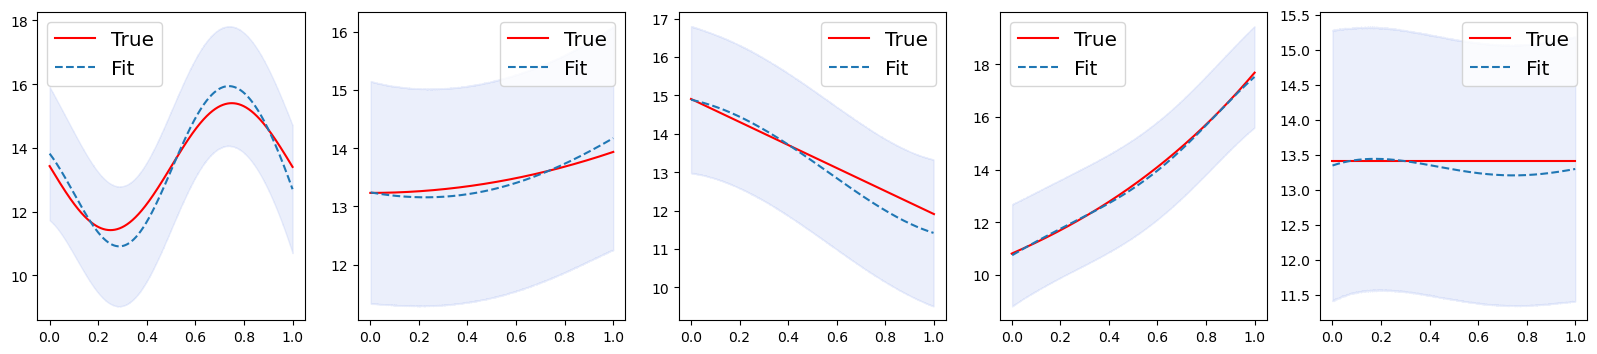

In [86]:
fig,ax=plt.subplots(1,5, figsize=(20, 4))

np.random.seed(2)
plot_x=np.random.uniform(0,1, (n,p)) #n points
plot_x[:,1:]=1/2
np.random.seed(3)
plot_noise=np.random.normal(0,1,n)
plot_y=a1*g1(plot_x[:,0])+a2(plot_x[:,0])*g2(plot_x[:,1])+a3(plot_x[:,0])*g3(plot_x[:,2])+a4*g4(plot_x[:,3])+plot_noise

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(plot_x))):
    x0=torch.from_numpy(plot_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<plot_y[i] and pred.detach().numpy()[0][0]+dd>plot_y[i]:
        coverage=coverage+1
    pred_xall.append(plot_x[i][0])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(plot_y[i])
    dist.append(dd)
    
band=np.array([pred_xall,pred_yall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plx=np.linspace(0,1,1000)
ply=a1*g1(plx)+a2(plx)*g2(1/2)+a3(plx)*g3(1/2)+a4*g4(1/2)
ax[0].plot(plx,ply,color='red')
ax[0].plot(sort_band.T[0],sort_band.T[1],linestyle='dashed')
ax[0].fill_between(sort_band.T[0],sort_band.T[2],sort_band.T[3],alpha=0.1,color='royalblue')
ax[0].legend(['True','Fit'],fontsize="x-large")

#######################1
np.random.seed(2)
plot_x=np.random.uniform(0,1, (n,p)) #n points
plot_x[:,0:1]=1/2
plot_x[:,2:]=1/2
np.random.seed(3)
plot_noise=np.random.normal(0,1,n)
plot_y=a1*g1(plot_x[:,0])+a2(plot_x[:,0])*g2(plot_x[:,1])+a3(plot_x[:,0])*g3(plot_x[:,2])+a4*g4(plot_x[:,3])+plot_noise

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(plot_x))):
    x0=torch.from_numpy(plot_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<plot_y[i] and pred.detach().numpy()[0][0]+dd>plot_y[i]:
        coverage=coverage+1
    pred_xall.append(plot_x[i][1])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(plot_y[i])
    dist.append(dd)
    
band=np.array([pred_xall,pred_yall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plx=np.linspace(0,1,1000)
ply=a1*g1(1/2)+a2(1/2)*g2(plx)+a3(1/2)*g3(1/2)+a4*g4(1/2)
ax[1].plot(plx,ply,color='red')
ax[1].plot(sort_band.T[0],sort_band.T[1],linestyle='dashed')
ax[1].fill_between(sort_band.T[0],sort_band.T[2],sort_band.T[3],alpha=0.1,color='royalblue')
ax[1].legend(['True','Fit'],fontsize="x-large")

#######################2
np.random.seed(2)
plot_x=np.random.uniform(0,1, (n,p)) #n points
plot_x[:,0:2]=1/2
plot_x[:,3:]=1/2
np.random.seed(3)
plot_noise=np.random.normal(0,1,n)
plot_y=a1*g1(plot_x[:,0])+a2(plot_x[:,0])*g2(plot_x[:,1])+a3(plot_x[:,0])*g3(plot_x[:,2])+a4*g4(plot_x[:,3])+plot_noise

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(plot_x))):
    x0=torch.from_numpy(plot_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<plot_y[i] and pred.detach().numpy()[0][0]+dd>plot_y[i]:
        coverage=coverage+1
    pred_xall.append(plot_x[i][2])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(plot_y[i])
    dist.append(dd)
    
band=np.array([pred_xall,pred_yall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plx=np.linspace(0,1,1000)
ply=a1*g1(1/2)+a2(1/2)*g2(1/2)+a3(1/2)*g3(plx)+a4*g4(1/2)
ax[2].plot(plx,ply,color='red')
ax[2].plot(sort_band.T[0],sort_band.T[1],linestyle='dashed')
ax[2].fill_between(sort_band.T[0],sort_band.T[2],sort_band.T[3],alpha=0.1,color='royalblue')
ax[2].legend(['True','Fit'],fontsize="x-large")

#######################3
np.random.seed(2)
plot_x=np.random.uniform(0,1, (n,p)) #n points
plot_x[:,0:3]=1/2
plot_x[:,4:]=1/2
np.random.seed(3)
plot_noise=np.random.normal(0,1,n)
plot_y=a1*g1(plot_x[:,0])+a2(plot_x[:,0])*g2(plot_x[:,1])+a3(plot_x[:,0])*g3(plot_x[:,2])+a4*g4(plot_x[:,3])+plot_noise

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(plot_x))):
    x0=torch.from_numpy(plot_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<plot_y[i] and pred.detach().numpy()[0][0]+dd>plot_y[i]:
        coverage=coverage+1
    pred_xall.append(plot_x[i][3])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(plot_y[i])
    dist.append(dd)
    
band=np.array([pred_xall,pred_yall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plx=np.linspace(0,1,1000)
ply=a1*g1(1/2)+a2(1/2)*g2(1/2)+a3(1/2)*g3(1/2)+a4*g4(plx)
ax[3].plot(plx,ply,color='red')
ax[3].plot(sort_band.T[0],sort_band.T[1],linestyle='dashed')
ax[3].fill_between(sort_band.T[0],sort_band.T[2],sort_band.T[3],alpha=0.1,color='royalblue')
ax[3].legend(['True','Fit'],fontsize="x-large")


#######################3
np.random.seed(2)
plot_x=np.random.uniform(0,1, (n,p)) #n points
plot_x[:,0:4]=1/2
plot_x[:,5:]=1/2
np.random.seed(3)
plot_noise=np.random.normal(0,1,n)
plot_y=a1*g1(plot_x[:,0])+a2(plot_x[:,0])*g2(plot_x[:,1])+a3(plot_x[:,0])*g3(plot_x[:,2])+a4*g4(plot_x[:,3])+plot_noise

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(plot_x))):
    x0=torch.from_numpy(plot_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<plot_y[i] and pred.detach().numpy()[0][0]+dd>plot_y[i]:
        coverage=coverage+1
    pred_xall.append(plot_x[i][4])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(plot_y[i])
    dist.append(dd)
    
band=np.array([pred_xall,pred_yall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plx=np.linspace(0,1,1000)
ply=[a1*g1(1/2)+a2(1/2)*g2(1/2)+a3(1/2)*g3(1/2)+a4*g4(1/2) for _ in range(1000)]
ax[4].plot(plx,ply,color='red')
ax[4].plot(sort_band.T[0],sort_band.T[1],linestyle='dashed')
ax[4].fill_between(sort_band.T[0],sort_band.T[2],sort_band.T[3],alpha=0.1,color='royalblue')
ax[4].legend(['True','Fit'],fontsize="x-large")
plt.show()

## RK

In [41]:
rff0=RandomFourierFeature(p,64,kernel='G',gamma=1)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=1)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(64,8,rff1)
        self.fc2 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0.01)


def MultiLayerKfold(kfold,param_grid):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    param_error=[]
    for param in tqdm(param_grid):
        k_error=[]
        for k in range(kfold):
            Kfold_val_x, Kfold_val_y=nntrain_x[int(n/5)*k:int(n/5)*(k+1)], nntrain_y[int(n/5)*k:int(n/5)*(k+1)]
            Kfold_train_x = torch.cat((nntrain_x[:int(n/5)*k],nntrain_x[int(n/5)*(k+1):]),dim = 0)
            Kfold_train_y = torch.cat((nntrain_y[:int(n/5)*k],nntrain_y[int(n/5)*(k+1):]),dim = 0)
           
            net = ResKernelNet()  #### ResKernelNet!
            net = net.to(device)
            torch.manual_seed(1)
            net.apply(init_weights)
            criterion=nn.MSELoss() 
            optimizer=optim.SGD(net.parameters(),lr=5e-4,momentum=0.9,weight_decay=param) #optim.Adam(...)
            kfoldtrain_loader = DataLoader(mydataset(Kfold_train_x, Kfold_train_y),batch_size=128, shuffle=True)
            
            for epoch in range(2000): 
                for x, y in kfoldtrain_loader: #for batch, (x, y) in enumerate(train_loader): 
                    x, y = x.to(device), y.to(device)
                    # Compute prediction error
                    y_pred = net(x)
                    y_pred = torch.squeeze(y_pred)
                    train_loss = criterion(y_pred, y)
                    # Backpropagation
                    optimizer.zero_grad() 
                    train_loss.backward()
                    optimizer.step()
            
            x0=Kfold_val_x[:].float()
            with torch.no_grad():
                x0 = x0.to(device)
                val_pred = net(x0)
            
            k_error.append(mean_squared_error(val_pred,Kfold_val_y))
        
        param_error.append(np.mean(k_error))
        
    print(param_error) 
    return param_grid[np.argmin(param_error)]  

bestweight=MultiLayerKfold(5,[1e-7,1e-6,1e-5,1e-4,1e-3])     
print(bestweight)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [21:39<00:00, 259.88s/it]

[1.2939619, 1.293951, 1.2938372, 1.2927063, 1.2870876]
0.001


In [117]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=128, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-4,momentum=0.9,weight_decay=bestweight) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        train_pred = net(x0)
    
    x0=torch.from_numpy(test_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        test_pred = net(x0)
    
    reskernel_trainloss.append(mean_squared_error(train_pred,train_y))
    reskernel_testloss.append(mean_squared_error(test_pred,test_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {reskernel_trainloss[-1]}
            Test set - loss: {reskernel_testloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=64, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 63.006970620367206
            Test set - loss: 64.89372081918593
            
epoch 100
            Train set - loss: 1.9124525507159682
            Test set - loss: 2.0232887946535563
            
epoch 200
            Train set - loss: 1.1518480948912164
            Test set - loss: 1.2905461027436318
            
epoch 300
            Train set - loss: 1.087998949936494
            Test set - loss: 1.2401617935162783
            
epoch 400
            Train set - loss: 1.0386400155939468
            Test set - loss: 1.206083851623464
            
epoch 500
            Train set - loss: 1.051965069857305
            Test set - loss: 1.2322732743405453
            
epoch 600
            Train set - loss: 1.0269446767996133


In [118]:
rk_x0=torch.from_numpy(test_x[:]).float()
with torch.no_grad():
    rk_x0 = rk_x0.to(device)
    rk_pred = net(rk_x0)

In [119]:
##conformal prediction
#predict

coverage=0
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i]).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(calibration_x))):
    x0=torch.from_numpy(calibration_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    if fFFf < 0:
        continue
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-calibration_y[i])/(np.sqrt(reskernel_trainloss[-1])*np.sqrt(fFFf+1))])
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(score)+1)*0.95
a=sorted_score[int(np.ceil(q))]

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(reskernel_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
    pred_xall.append(test_x[i][0])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(test_y[i])
    dist.append(dd)
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 4000/4000 [00:03<00:00, 1203.25it/s]

length 4.382339910030365
95 coverage 0.95125


100%|██████████| 2000/2000 [00:01<00:00, 1230.94it/s]


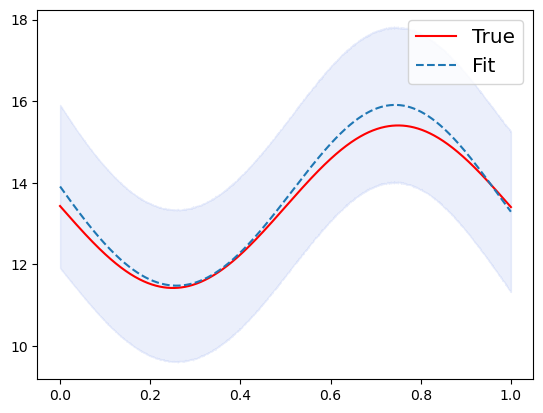

In [120]:
np.random.seed(2)
plot_x=np.random.uniform(0,1, (n,p)) #n points
plot_x[:,1:]=1/2
np.random.seed(3)
plot_noise=np.random.normal(0,1,n)
plot_y=a1*g1(plot_x[:,0])+a2(plot_x[:,0])*g2(plot_x[:,1])+a3(plot_x[:,0])*g3(plot_x[:,2])+a4*g4(plot_x[:,3])+plot_noise

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(plot_x))):
    x0=torch.from_numpy(plot_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<plot_y[i] and pred.detach().numpy()[0][0]+dd>plot_y[i]:
        coverage=coverage+1
    pred_xall.append(plot_x[i][0])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(plot_y[i])
    dist.append(dd)
    
band=np.array([pred_xall,pred_yall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plx=np.linspace(0,1,1000)
ply=a1*g1(plx)+a2(plx)*g2(1/2)+a3(plx)*g3(1/2)+a4*g4(1/2)
plt.plot(plx,ply,color='red')
plt.plot(sort_band.T[0],sort_band.T[1],linestyle='dashed')
plt.fill_between(sort_band.T[0],sort_band.T[2],sort_band.T[3],alpha=0.1,color='royalblue')
plt.legend(['True','Fit'],fontsize="x-large")
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1433.77it/s]


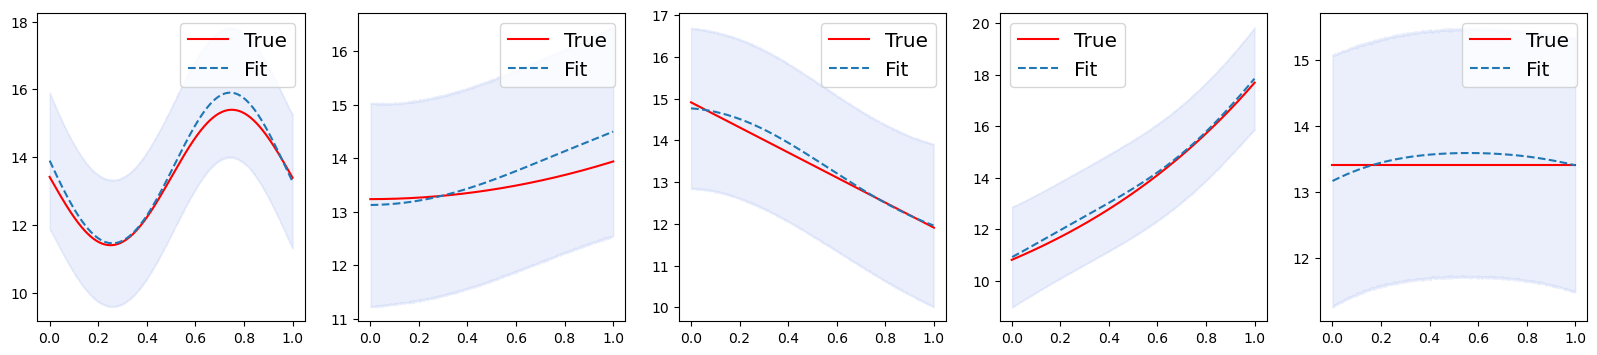

In [121]:
fig,ax=plt.subplots(1,5, figsize=(20, 4))

np.random.seed(2)
plot_x=np.random.uniform(0,1, (n,p)) #n points
plot_x[:,1:]=1/2
np.random.seed(3)
plot_noise=np.random.normal(0,1,n)
plot_y=a1*g1(plot_x[:,0])+a2(plot_x[:,0])*g2(plot_x[:,1])+a3(plot_x[:,0])*g3(plot_x[:,2])+a4*g4(plot_x[:,3])+plot_noise

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(plot_x))):
    x0=torch.from_numpy(plot_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<plot_y[i] and pred.detach().numpy()[0][0]+dd>plot_y[i]:
        coverage=coverage+1
    pred_xall.append(plot_x[i][0])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(plot_y[i])
    dist.append(dd)
    
band=np.array([pred_xall,pred_yall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plx=np.linspace(0,1,1000)
ply=a1*g1(plx)+a2(plx)*g2(1/2)+a3(plx)*g3(1/2)+a4*g4(1/2)
ax[0].plot(plx,ply,color='red')
ax[0].plot(sort_band.T[0],sort_band.T[1],linestyle='dashed')
ax[0].fill_between(sort_band.T[0],sort_band.T[2],sort_band.T[3],alpha=0.1,color='royalblue')
ax[0].legend(['True','Fit'],fontsize="x-large")

#######################1
np.random.seed(2)
plot_x=np.random.uniform(0,1, (n,p)) #n points
plot_x[:,0:1]=1/2
plot_x[:,2:]=1/2
np.random.seed(3)
plot_noise=np.random.normal(0,1,n)
plot_y=a1*g1(plot_x[:,0])+a2(plot_x[:,0])*g2(plot_x[:,1])+a3(plot_x[:,0])*g3(plot_x[:,2])+a4*g4(plot_x[:,3])+plot_noise

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(plot_x))):
    x0=torch.from_numpy(plot_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<plot_y[i] and pred.detach().numpy()[0][0]+dd>plot_y[i]:
        coverage=coverage+1
    pred_xall.append(plot_x[i][1])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(plot_y[i])
    dist.append(dd)
    
band=np.array([pred_xall,pred_yall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plx=np.linspace(0,1,1000)
ply=a1*g1(1/2)+a2(1/2)*g2(plx)+a3(1/2)*g3(1/2)+a4*g4(1/2)
ax[1].plot(plx,ply,color='red')
ax[1].plot(sort_band.T[0],sort_band.T[1],linestyle='dashed')
ax[1].fill_between(sort_band.T[0],sort_band.T[2],sort_band.T[3],alpha=0.1,color='royalblue')
ax[1].legend(['True','Fit'],fontsize="x-large")

#######################2
np.random.seed(2)
plot_x=np.random.uniform(0,1, (n,p)) #n points
plot_x[:,0:2]=1/2
plot_x[:,3:]=1/2
np.random.seed(3)
plot_noise=np.random.normal(0,1,n)
plot_y=a1*g1(plot_x[:,0])+a2(plot_x[:,0])*g2(plot_x[:,1])+a3(plot_x[:,0])*g3(plot_x[:,2])+a4*g4(plot_x[:,3])+plot_noise

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(plot_x))):
    x0=torch.from_numpy(plot_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<plot_y[i] and pred.detach().numpy()[0][0]+dd>plot_y[i]:
        coverage=coverage+1
    pred_xall.append(plot_x[i][2])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(plot_y[i])
    dist.append(dd)
    
band=np.array([pred_xall,pred_yall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plx=np.linspace(0,1,1000)
ply=a1*g1(1/2)+a2(1/2)*g2(1/2)+a3(1/2)*g3(plx)+a4*g4(1/2)
ax[2].plot(plx,ply,color='red')
ax[2].plot(sort_band.T[0],sort_band.T[1],linestyle='dashed')
ax[2].fill_between(sort_band.T[0],sort_band.T[2],sort_band.T[3],alpha=0.1,color='royalblue')
ax[2].legend(['True','Fit'],fontsize="x-large")

#######################3
np.random.seed(2)
plot_x=np.random.uniform(0,1, (n,p)) #n points
plot_x[:,0:3]=1/2
plot_x[:,4:]=1/2
np.random.seed(3)
plot_noise=np.random.normal(0,1,n)
plot_y=a1*g1(plot_x[:,0])+a2(plot_x[:,0])*g2(plot_x[:,1])+a3(plot_x[:,0])*g3(plot_x[:,2])+a4*g4(plot_x[:,3])+plot_noise

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(plot_x))):
    x0=torch.from_numpy(plot_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<plot_y[i] and pred.detach().numpy()[0][0]+dd>plot_y[i]:
        coverage=coverage+1
    pred_xall.append(plot_x[i][3])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(plot_y[i])
    dist.append(dd)
    
band=np.array([pred_xall,pred_yall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plx=np.linspace(0,1,1000)
ply=a1*g1(1/2)+a2(1/2)*g2(1/2)+a3(1/2)*g3(1/2)+a4*g4(plx)
ax[3].plot(plx,ply,color='red')
ax[3].plot(sort_band.T[0],sort_band.T[1],linestyle='dashed')
ax[3].fill_between(sort_band.T[0],sort_band.T[2],sort_band.T[3],alpha=0.1,color='royalblue')
ax[3].legend(['True','Fit'],fontsize="x-large")


#######################3
np.random.seed(2)
plot_x=np.random.uniform(0,1, (n,p)) #n points
plot_x[:,0:4]=1/2
plot_x[:,5:]=1/2
np.random.seed(3)
plot_noise=np.random.normal(0,1,n)
plot_y=a1*g1(plot_x[:,0])+a2(plot_x[:,0])*g2(plot_x[:,1])+a3(plot_x[:,0])*g3(plot_x[:,2])+a4*g4(plot_x[:,3])+plot_noise

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(plot_x))):
    x0=torch.from_numpy(plot_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<plot_y[i] and pred.detach().numpy()[0][0]+dd>plot_y[i]:
        coverage=coverage+1
    pred_xall.append(plot_x[i][4])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(plot_y[i])
    dist.append(dd)
    
band=np.array([pred_xall,pred_yall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plx=np.linspace(0,1,1000)
ply=[a1*g1(1/2)+a2(1/2)*g2(1/2)+a3(1/2)*g3(1/2)+a4*g4(1/2) for _ in range(1000)]
ax[4].plot(plx,ply,color='red')
ax[4].plot(sort_band.T[0],sort_band.T[1],linestyle='dashed')
ax[4].fill_between(sort_band.T[0],sort_band.T[2],sort_band.T[3],alpha=0.1,color='royalblue')
ax[4].legend(['True','Fit'],fontsize="x-large")
plt.show()

In [6]:
print(mean_squared_error(krr_pred,test_y))
print(mean_squared_error(rf_pred,test_y))
print(mean_squared_error(kernel_pred,test_y))
print(mean_squared_error(rk_pred,test_y))

1.2646023956203407
1.239894330268793
1.2070176337367649
1.1957198249548207
